# Province MFCC Baseline — Reporting Notebook

This notebook reproduces the baseline run from `train_province_mfcc_baseline.py` and adds reporting visuals:

- Class distribution after filtering/capping
- Fold-level accuracy
- Overall + normalized confusion matrices
- Per-class precision/recall/F1

Run cells top-to-bottom. Edit the configuration + feature-building section to match your script.


In [28]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

SCRIPT_PATH = Path("train_province_mfcc_baseline.py").resolve()
print("Script path:", SCRIPT_PATH)
print("Python:", sys.version)


Script path: /Users/cianan/Documents/College/GitHub/FYP/Prototype2/Scripts/train_province_mfcc_baseline.py
Python: 3.12.12 (main, Oct  9 2025, 11:07:00) [Clang 16.0.0 (clang-1600.0.26.6)]


## Configuration

Set your dataset paths + column names to match the script.
Use speaker-safe splits (`GroupKFold`) for speech data so the same speaker never appears in both train and test.


In [29]:
# Paths (edit)
INDEX_CSV = "/Users/cianan/Documents/College/GitHub/FYP/Prototype2/all_segments_index_with_resolved_paths.csv"          # Path(".../your_index.csv").resolve()
AUDIO_BASE_DIR = None     # Only needed if you compute MFCCs from wav paths

# Column names in your index CSV
COL_PROVINCE = "native_province"     # or "native_province"
COL_SPEAKER  = "speaker"  # speaker id for grouping
COL_AUDIO    = "segment_file_resolved" # wav path if computing MFCCs here

# Filters / caps (match your .py)
ALLOWED_PROVINCES = ["Connacht", "Leinster", "Munster", "Ulster"]
MAX_PER_PROVINCE = None       # e.g. 400, or None

# Cross-validation
N_SPLITS = 5
USE_GROUP_SPLIT = True  # recommended

# Baseline model (swap to match your script if needed)
BASELINE_MODEL = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"
)

if(MAX_PER_PROVINCE != None):
    print("Max Per Province:", MAX_PER_PROVINCE)

print("Allowed provinces:", ALLOWED_PROVINCES)


Allowed provinces: ['Connacht', 'Leinster', 'Munster', 'Ulster']


## Load and filter the index

This should mirror the filtering/capping you do in the script.


In [30]:
if INDEX_CSV is None:
    raise ValueError("Set INDEX_CSV before running.")

df = pd.read_csv(INDEX_CSV).copy()
df[COL_PROVINCE] = df[COL_PROVINCE].astype(str).str.strip()

# Filter to target provinces
df = df[df[COL_PROVINCE].isin(ALLOWED_PROVINCES)].reset_index(drop=True)
print("Rows after province filter:", len(df))

# Optional cap per province
if MAX_PER_PROVINCE is not None:
    df = (
        df.groupby(COL_PROVINCE, group_keys=False)
          .head(MAX_PER_PROVINCE)
          .reset_index(drop=True)
    )
    print("Rows after cap:", len(df))

class_counts = df[COL_PROVINCE].value_counts().reindex(ALLOWED_PROVINCES).fillna(0).astype(int)
class_counts


Rows after province filter: 1656


native_province
Connacht    255
Leinster    484
Munster     350
Ulster      567
Name: count, dtype: int64

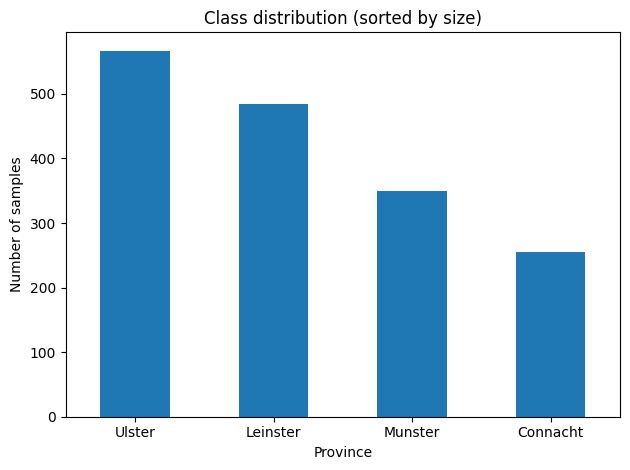

In [31]:
class_counts_sorted = class_counts.sort_values(ascending=False)

class_counts_sorted.plot(kind="bar")
plt.title("Class distribution (sorted by size)")
plt.xlabel("Province")
plt.ylabel("Number of samples")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Build features (MFCC baseline)

Replace the placeholder code with your **exact** MFCC feature extraction / loading logic from
`train_province_mfcc_baseline.py`.

This cell must produce:
- `X` (NumPy array, shape `[n_samples, n_features]`)
- `y` (province labels)
- `groups` (speaker ids, for GroupKFold)


In [32]:
# Replace this with your script's exact feature building.
# Placeholder assumes MFCC features exist as columns in the CSV.

feature_cols = [c for c in df.columns if c.startswith("mfcc_") or c.startswith("feat_")]

if len(feature_cols) == 0:
    raise ValueError(
        "No feature columns found. Paste your MFCC extraction/loading code here "
        "or load your precomputed feature columns."
    )

X = df[feature_cols].to_numpy(dtype=np.float32)
y = df[COL_PROVINCE].to_numpy()
groups = df[COL_SPEAKER].to_numpy() if COL_SPEAKER in df.columns else None

print("Feature matrix shape:", X.shape)
print("Groups available:", groups is not None)


ValueError: No feature columns found. Paste your MFCC extraction/loading code here or load your precomputed feature columns.

## Cross-validation run + capture predictions

Runs k-fold CV, prints fold reports, and stores all predictions for plots.


In [ ]:
labels_sorted = sorted(ALLOWED_PROVINCES)

if USE_GROUP_SPLIT:
    if groups is None:
        raise ValueError("USE_GROUP_SPLIT=True but groups is None. Ensure COL_SPEAKER exists.")
    cv = GroupKFold(n_splits=N_SPLITS)
    split_iter = cv.split(X, y, groups=groups)
else:
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    split_iter = cv.split(X, y)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", BASELINE_MODEL),
])

all_true, all_pred = [], []
fold_acc = []

for fold_i, (train_idx, test_idx) in enumerate(split_iter, start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)

    all_true.extend(list(y_test))
    all_pred.extend(list(y_hat))

    acc = (y_hat == y_test).mean()
    fold_acc.append(acc)

    print(f"Fold {fold_i}/{N_SPLITS}")
    print("Test samples:", len(test_idx))
    print(classification_report(y_test, y_hat, labels=labels_sorted, zero_division=0))

print("=== Overall (all folds combined) ===")
print(classification_report(all_true, all_pred, labels=labels_sorted, zero_division=0))

cm = confusion_matrix(all_true, all_pred, labels=labels_sorted)
print("Confusion matrix (labels in sorted order):")
print(labels_sorted)
print(cm)


NameError: name 'groups' is not defined

In [ ]:
plt.figure()
plt.plot(range(1, len(fold_acc) + 1), fold_acc, marker="o")
plt.title("Fold accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(range(1, len(fold_acc) + 1))
plt.tight_layout()
plt.show()

print("Mean accuracy:", float(np.mean(fold_acc)))
print("Std accuracy:", float(np.std(fold_acc)))


In [ ]:
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)
disp.plot(values_format="d")
plt.title("Confusion matrix (counts)")
plt.tight_layout()
plt.show()


In [ ]:
cm_norm = cm.astype(np.float64)
row_sums = cm_norm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_norm, row_sums, out=np.zeros_like(cm_norm), where=row_sums != 0)

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels_sorted)
disp.plot(values_format=".2f")
plt.title("Confusion matrix (row-normalized)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, sup = precision_recall_fscore_support(
    all_true, all_pred, labels=labels_sorted, zero_division=0
)

metrics_df = pd.DataFrame({
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": sup
}, index=labels_sorted)

metrics_df
plt.figure()

metrics_df[["precision", "recall", "f1"]].plot(kind="bar")
plt.title("Per-class metrics")
plt.xlabel("Province")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [ ]:
OUT_DIR = Path("notebook_outputs").resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

np.savetxt(OUT_DIR / "confusion_matrix_counts.csv", cm, delimiter=",", fmt="%d")
np.savetxt(OUT_DIR / "confusion_matrix_row_normalized.csv", cm_norm, delimiter=",", fmt="%.6f")
metrics_df.to_csv(OUT_DIR / "per_class_metrics.csv")

print("Saved to:", OUT_DIR)
